# Cats vs. dogs classifier
## Folder structure preprocessing

In [ ]:
!unzip kaggle_data.zip
!rm kaggle_data.zip
!mkdir kaggle_data
!mv test.zip kaggle_data
!mv train.zip kaggle_data
!mv sample_submission.csv kaggle_data

In [ ]:
%cd kaggle_data

!unzip test.zip
!unzip train.zip

%cd ..

In [ ]:
!mkdir kaggle_data/input
!mkdir kaggle_data/input/dogs
!mkdir kaggle_data/input/cats
!mv kaggle_data/test kaggle_data/input/dogs

In [4]:
import os
import shutil
import random

def distribute_train_validation_split(validation_size=0.2):

    all_images = os.listdir('./kaggle_data/train/')
    random.shuffle(all_images)

    all_dogs = list(filter(lambda image: 'dog' in image, all_images))
    all_cats = list(filter(lambda image: 'cat' in image, all_images))

    index_to_split = int(len(all_dogs) - len(all_dogs) * validation_size)
    training_dogs = all_dogs[:index_to_split]
    validation_dogs = all_dogs[index_to_split:]
    training_cats = all_cats[:index_to_split]
    validation_cats = all_cats[index_to_split:]

    shutil.rmtree('./processed_data', ignore_errors=True)
    os.makedirs('./processed_data/train/dogs/', exist_ok=True)
    os.makedirs('./processed_data/train/cats/', exist_ok=True)
    os.makedirs('./processed_data/validation/dogs/', exist_ok=True)
    os.makedirs('./processed_data/validation/cats/', exist_ok=True)

    copy_images_to_dir(training_dogs, './processed_data/train/dogs')
    copy_images_to_dir(validation_dogs, './processed_data/validation/dogs')
    copy_images_to_dir(training_cats, './processed_data/train/cats')
    copy_images_to_dir(validation_cats, './processed_data/validation/cats')

def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'./kaggle_data/train/{image}', f'{destination}/{image}')


In [5]:
distribute_train_validation_split(0.20)

## Setting up environment

In [ ]:
%pip install scipy
%pip install pandas

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
DIMENSIONS = 200

## Training

In [5]:
train_imagedatagenerator = ImageDataGenerator(
                            rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
validation_imagedatagenerator = ImageDataGenerator(rescale=1/255.0)

train_iterator = train_imagedatagenerator.flow_from_directory(
    './processed_data/train',
    target_size=(DIMENSIONS, DIMENSIONS),
    batch_size=200,
    class_mode='binary')

validation_iterator = validation_imagedatagenerator.flow_from_directory(
    './processed_data/validation',
    target_size=(DIMENSIONS, DIMENSIONS),
    batch_size=50,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(DIMENSIONS, DIMENSIONS, 3)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [8]:
history = model.fit(train_iterator,
                    validation_data=validation_iterator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=100)

Epoch 1/100
100/100 [==============================] - 171s 2s/step - loss: 0.8158 - accuracy: 0.5721 - val_loss: 0.6468 - val_accuracy: 0.6188
Epoch 2/100
100/100 [==============================] - 149s 1s/step - loss: 0.6187 - accuracy: 0.6583 - val_loss: 0.5715 - val_accuracy: 0.6982
Epoch 3/100
100/100 [==============================] - 174s 2s/step - loss: 0.5818 - accuracy: 0.6918 - val_loss: 0.5387 - val_accuracy: 0.7206
Epoch 4/100
100/100 [==============================] - 151s 2s/step - loss: 0.5623 - accuracy: 0.7070 - val_loss: 0.5245 - val_accuracy: 0.7300
Epoch 5/100
100/100 [==============================] - 146s 1s/step - loss: 0.5407 - accuracy: 0.7243 - val_loss: 0.5057 - val_accuracy: 0.7454
Epoch 6/100
100/100 [==============================] - 146s 1s/step - loss: 0.5384 - accuracy: 0.7266 - val_loss: 0.4984 - val_accuracy: 0.7472
Epoch 7/100
100/100 [==============================] - 146s 1s/step - loss: 0.5173 - accuracy: 0.7442 - val_loss: 0.4610 - val_accuracy:

## Plotting results and saving it

In [9]:
import matplotlib.pyplot as plt

def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

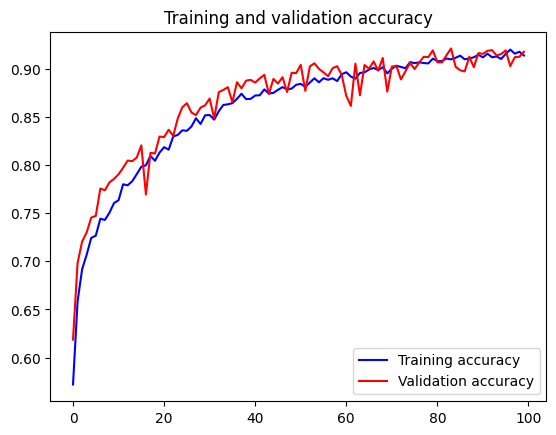

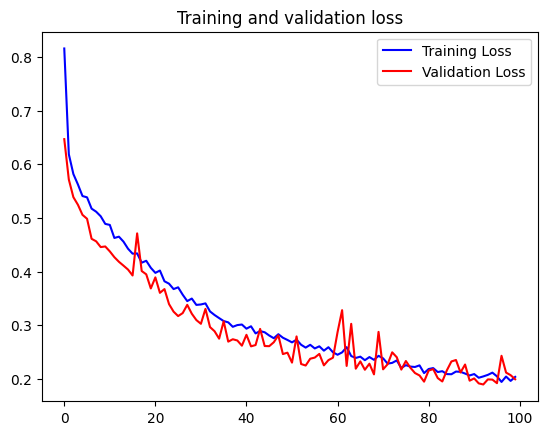

In [10]:
plot_result(history)

In [18]:
test_generator = ImageDataGenerator(rescale=1. / 255)

test_iterator = test_generator.flow_from_directory(
    './kaggle_data/input/',
    target_size=(DIMENSIONS, DIMENSIONS),
    shuffle=False,
    class_mode='binary',
    batch_size=1)

ids = []
for filename in test_iterator.filenames:
    ids.append(int(filename.split('/')[1].split('.')[0]))

predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
predictions = []
for index, prediction in enumerate(predict_result):
    predictions.append([ids[index], prediction[0]])
predictions.sort()

Found 12500 images belonging to 2 classes.
12500/12500 [==============================] - 50s 4ms/step


In [22]:
import pandas as pd


df = pd.DataFrame(data=predictions, index=range(1, 12501), columns=['id', 'label'])
df = df.set_index(['id'])
df.to_csv('submission.csv')